## User Guide

### Author
This repository and accompanying tutorial notebooks were developed by **Sharon Xalxo** as part of ongoing research on quantum algorithms for differential equations, Chebyshev spectral methods, and Quantum Singular Value Transformation (QSVT).



### Overview

This repository contains a complete, research-grade implementation of a **Chebyshev–QSVT differential equation solver**, including:

- Construction of Chebyshev discretizations for linear ODEs/PDEs  
- Hermitian dilation and block encoding (Qiskit + PennyLane hybrid)  
- QSVT phase synthesis (PyQSP)  
- Linear-system solving via QSVT  
- Real-valued Hadamard-test extraction circuits  
- Sherman–Morrison normalization for boundary conditions  
- Classical post-processing utilities (Chebyshev transforms, Clenshaw evaluation, derivatives)

The code is written to match the structure and style of modern quantum-algorithm research papers and tutorials.



### Repository Structure

- **QSVT core implementation** — the main polynomial transformation engine  
- **Block encoding utilities** — PennyLane-based single-ancilla block encodings  
- **Chebyshev tools** — nodes, DCT-I transforms, Clenshaw evaluation, derivatives  
- **Differential-equation solvers** — ODE templates, normalization logic  
- **Real-valued extraction** — Hadamard-test LCU solver for real solutions  
- **Examples / Tutorials** — annotated Jupyter notebooks reproducing experiments  

The notebooks are self-contained and can be executed directly on standard Qiskit simulators (e.g., `AerSimulator`).



### Usage Notes

- Ensure that you have recent versions of **Qiskit**, **PennyLane**, **PyQSP**, **NumPy**, and **Matplotlib** installed.  
- The solver outputs both:
  - the **statevector-based solution** (high precision, noiseless mode), and  
  - the **measurement-based real solution** (ancilla-structured Hadamard-test output).  
- For differential equations of the form $u'(x) = \alpha\,u(x)$, the provided Sherman–Morrison utilities compute the correct normalization factor
  $$
  \gamma = 1 + v^\top z,
  $$
  and reconstruct the final Chebyshev coefficients and nodal solutions.



### How to Cite This Work

If you use this repository, its methods, or the QSVT–Chebyshev linear-system solver in academic work, please cite it as follows:

**Standard citation text:**

> This work uses the Chebyshev–QSVT differential equation solver developed by  
> **Sharon Xalxo (2025)**, including block-encoding methods, PyQSP-derived phase sequences, and real-valued Hadamard-test QSVT extraction circuits.


### BibTeX Citation

You may use the following BibTeX entry:

```bibtex
@misc{Sxal2025QSVTv1,
  author       = {Sharon Xalxo},
  title        = {Chebyshev-QSVT Differential Equation Solver: 
                  Block Encoding, Phase Synthesis, and 
                  Real-Valued Linear System Extraction},
  year         = {2025},
  howpublished = {GitHub repository},
  note         = {QSVT-based spectral method implementation for differential equations},
}


---
# Chebyshev-Based Differential Equation Solving with QSVT

This tutorial demonstrates how to use **Quantum Singular Value Transformation (QSVT)** as the core engine of a **Chebyshev-based differential equation solver**.

The overall pipeline is:

- We start from a **differential equation** that is discretized in a **Chebyshev polynomial basis**, yielding a linear system: $Ax = b$
- The matrix $A$ encodes the Chebyshev-discretized operator (e.g., a differential operator with boundary conditions).
- We implement a **QSVT-based linear system solver** that approximates the inverse function $(f(x) \approx \frac{1}{x})$ on the spectrum of a suitably scaled operator.
- The method currently performs the **Chebyshev transform** (between physical and Chebyshev coefficient space) **classically** using FFT-based routines (not shown explicitly here). The long-term goal is to replace this step with a **fully quantum Chebyshev transform circuit**, so that the entire pipeline is quantum-native.

Key features of this notebook:

- **QSVT as a linear system solver.** We implement QSVT for both **scalars** and **matrices**, using a polynomial approximation to $\frac{1}{x}$ built by **PyQSP**.
- **Non-Hermitian support via Hermitian dilation.** General (non-Hermitian) matrices are treated via a Hermitian dilation, allowing us to apply standard QSVT techniques.
- **Block encoding via PennyLane.** All quantum logic is written in **Qiskit**, but the block encoding of matrices is delegated to **PennyLane’s `qml.BlockEncode()`**, which provides a single-ancilla block-encoding.
- **Phase-convention conversion.** PyQSP returns phases in the **Wx convention**; we convert these phases internally to the **Reflection convention** used by our QSVT implementation.
- **Measurement and interpretation.** We show how to interpret the measurement probabilities to recover the normalized solution vector, including the relevant normalization factors.
- **Numerical observations.** All tests here are run on a **noiseless `AerSimulator`**, and the QSVT-based solutions match classical solutions with high precision. In practice, we observe that the method remains stable even when the matrix condition number is up to roughly **twice the chosen $\kappa$** used for phase generation.

We will build up the solver in stages:

1. Generate QSVT phases for the function $(f(x) \approx \frac{1}{x})$.
2. Implement a reusable **QSVT helper class** supporting scalar and matrix inputs.
3. Construct test matrices $A$ and right-hand sides $\ket{b}$.
4. Use QSVT to approximate $A^{-1}$ directly.
5. Solve linear systems with **full complex amplitudes** (tomography-based readout).
6. Solve **real-valued** linear systems using a **Hadamard-test-style LCU construction**, so that the solution can be recovered directly from measurement statistics.
7. Conclude with a **roadmap for future work**, including quantum Chebyshev transforms and multi-ancilla block encodings.


## 0. Chebyshev-Space Formulation and Linear System Construction

Before we focus on the QSVT implementation itself, it is useful to spell out how the linear system arises from the Chebyshev spectral discretization of a differential equation, and how the quantum output is interpreted back in physical space.

### 0.1 Differential Equation and Chebyshev Domain

The motivating differential equation in this project is the simple first-order ODE:

$$
u'(x) = \alpha u(x) \space \space (\alpha > 1), \qquad x \in [-1,1], \qquad u(-1) = 0.367.
$$

The choice of the interval $[-1,1]$ matches the natural domain of Chebyshev polynomials $T_n(x)$.  
We work with a truncated expansion of degree $N$ (e.g., $N=3$ for a 4×4 toy model), so that

$$
u(x) \approx \sum_{n=0}^N a_n T_n(x).
$$

There are two equivalent representation spaces:

**Nodal (collocation) space:** values of $u(x)$ at Chebyshev–Gauss–Lobatto nodes

$$
x_j = \cos\left(\frac{j\pi}{N}\right), \qquad j = 0,1,\dots,N,
$$

collected into a vector

$$
u_{\text{nodal}} = [u(x_0), u(x_1), \dots, u(x_N)]^\top.
$$

**Coefficient (spectral) space:** Chebyshev coefficients

$$
a = [a_0, a_1, \dots, a_N]^\top.
$$

They are related by the discrete Chebyshev transform:

$$
u_{\text{nodal}} = T a, \qquad a = T^{-1} u_{\text{nodal}},
$$

where $T$ is the $(N+1)\times(N+1)$ Chebyshev Transform (DCT-I) matrix with entries $T_{j,k} = T_k(x_j)$.



### 0.2 Differentiation and Construction of the Linear System

In coefficient space, differentiation acts via the matrix $D_c$ derived from Chebyshev recurrence:

$$
a'_{\text{spec}} = D_c \, a.
$$

Imposing $u'(x) = \alpha u(x)$ in spectral space:

$$
D_c \, a = \alpha a.
$$

Rewriting gives the linear system:

$$
(D_c - \alpha I)\, a = 0.
$$

This is ill-posed because the trivial solution $a = 0$ satisfies it.  
We fix this by imposing the boundary condition.



We enforce the initial condition at $x = -1$.  
For $N=3$, the Chebyshev–Gauss–Lobatto nodes are:

$$
x_0 = 1, \quad x_1 = \tfrac{1}{2}, \quad x_2 = -\tfrac{1}{2}, \quad x_3 = -1.
$$

The last node corresponds to $x=-1$.

Define the Lagrange cardinal vector:

$$
\ell = [0, 0, 0, 1]^\top.
$$

The boundary condition becomes the nodal vector:

$$
r = 0.367 \, \ell = [0,0,0,0.367]^\top.
$$

Transform to coefficient space:

$$
c = T^{-1} r.
$$

We now solve for an intermediate vector $z$:

$$
A z = c, \qquad A := D_c - \alpha I.
$$

This is the linear system targeted by the QSVT solver.

- Classically:
  $$
  z = A^{-1} c.
  $$

- Quantum (QSVT):
  Block-encode $A$ and apply the QSVT polynomial for $\frac{1}{x}$, so the amplitudes encode $z$ up to normalization.



### 0.3 Normalization and Final Chebyshev Coefficients

Sherman–Morrison rank-one correction gives a scalar normalization:

$$
\gamma = 1 + v^\top z.
$$

Final Chebyshev coefficients:

$$
a = \frac{1}{\gamma} z.
$$

Quantum produces $z$ (up to scale).  
Classical post-processing computes $\gamma$ and rescales.



### 0.4 Data Extraction and Reconstruction in Physical Space

There are two extraction modes:

1. **Statevector / tomography mode**

   The first column of the unitary (or output state) gives amplitudes proportional to $z$.
   After scaling:

   $$
   a = \frac{z}{\gamma}.
   $$

2. **Measurement-based, real-valued mode**

   A Hadamard-test / LCU construction encodes the real part of $z$ directly into measurement probabilities.
   After scaling, we recover $z$ without tomography.



Once $a$ is known, the physical-space solution is:

$$
u_{\text{nodal}} = T a.
$$

This approximates $u(x)$ at the collocation points and constitutes the final output of the Chebyshev spectral solver.




## 1. Imports and Dependencies

In this section we import all required libraries:

- **NumPy** for classical numerical operations.
- **Qiskit** (circuits, registers, operators, statevectors, transpilation, Aer simulator, and plotting utilities) for constructing and simulating quantum circuits.
- **PyQSP** for generating QSVT phase angles for the approximation $f(x) \approx \frac{1}{x}$.
- **PennyLane** (`qml`) for constructing **block-encodings** of matrices via `qml.BlockEncode`.
- Plotting helpers for visualizing measurement distributions.

All quantum circuits in this notebook are simulated on a **noiseless `AerSimulator`**, so we can directly compare with classical solutions and study numerical behavior without hardware noise.


In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Operator, Statevector
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_distribution, plot_histogram
import pyqsp
from pyqsp import angle_sequence, response
import pennylane as qml

## 2. Generating QSVT Phases for $f(x) \approx \frac{1}{x}$

QSVT implements polynomial transformations of singular values or eigenvalues. To use QSVT as a **linear system solver**, we need a polynomial approximation of the function
$$f(x) \approx \frac{1}{x}$$
over a controlled spectral domain $[\frac{1}{\kappa}, 1]$, where $\kappa$ is an upper bound on the condition number of the matrix.

In this cell:

- We call **PyQSP**’s `PolyOneOverX` generator to:
  - Construct the polynomial coefficients approximating $\frac{1}{x}$ on the domain $[\frac{1}{\kappa}, 1]$.
  - Obtain a **global scaling factor** $s$, which ensures the polynomial is bounded in magnitude.
- We use `QuantumSignalProcessingPhases` to compute a sequence of **phase angles** in the **Wx convention**.
- These phases, together with the scaling $s$, will be fed into our QSVT routines later. Internally, our QSVT implementation converts from Wx to the **Reflection convention** required by our block-encoded circuits.

We set a representative value of $\kappa = 5$ in this notebook. In the context of Chebyshev-based PDE solvers, $\kappa$ is chosen based on the spectral properties of the discretized operator.


In [2]:
def generate_phases(kappa):
    pcoefs, s = pyqsp.poly.PolyOneOverX().generate(kappa, return_coef=True, ensure_bounded=True, return_scale=True, )
    phi_pyqsp = pyqsp.angle_sequence.QuantumSignalProcessingPhases(pcoefs, signal_operator="Wx", tolerance=1e-06)
    return phi_pyqsp, s
kappa = 5
phi_qsp, s = generate_phases(kappa)

b=97, j0=28
[PolyOneOverX] minimum [-6.3057238] is at [-0.11392906]: normalizing
[PolyOneOverX] bounding to 0.9


## 3. QSVT Helper Class: Scalar and Matrix Transformations

This cell defines the core **`QSVT` helper class**, which encapsulates all QSVT-related functionality used in the notebook:

### 3.1 Input Type Handling

- `check_input(self, x)`  
  Distinguishes between:
  - **Scalar** input: a single real number $x \in \mathbb{R}$.
  - **Matrix** input: a 2D NumPy array or list representing a numeric matrix.
- This allows us to reuse the same high-level interface for both scalar and matrix QSVT applications.

### 3.2 Validity Domain of the Polynomial

- `is_in_range(self, kappa, H)`  
  Checks that the eigenvalues / singular values of the (normalized) matrix lie within the **domain** required by the polynomial generated by PyQSP, roughly $[\frac{1}{\kappa}, 1]$ after appropriate scaling.
- This ensures that applying QSVT with the given phases is mathematically valid for the target operator.

### 3.3 Scalar QSVT (`qsvt_scalar`)

- `qsvt_scalar(self, x, phases, s)`  
  Implements QSVT for a **single scalar** $x \in [-1,1]$:
  - Uses a **1-qubit block-encoding** of the scalar `x`:
    $
      W(x) =
      \begin{pmatrix}
      x & i\sqrt{1-x^2} \\
      i\sqrt{1-x^2} & x
      \end{pmatrix},
    $
    such that $W$ encodes the scalar in its top-left element.
  - Applies the **QSP sequence** using the input phase list `phases`, which come from PyQSP (initially in Wx convention).
  - Returns:
    - The Qiskit circuit implementing the scalar QSVT.
    - A scale factor $\frac{1}{s}$ (from PyQSP’s polynomial generation).
    - The effective dimension of the block (1 qubit).

This provides a **scalar-reference implementation** of QSVT that is useful for debugging and verifying the matrix version.

### 3.4 Matrix QSVT with Hermitian Dilation and Block Encoding

- `qsvt_matrix(self, A, phi, s)`  
  Extends QSVT to **matrices** $A$:

  1. **Hermitian dilation for non-Hermitian matrices.**  
     - Implements a dilation
       $
         H = \begin{pmatrix}
         0 & A^\dagger \\
         A & 0
         \end{pmatrix}
       $
       via `hermitian_dilation(M)` whenever $A$ is not Hermitian.
     - If $A$ is Hermitian, we simply set $H = A$.
     - This allows us to apply Hermitian QSVT machinery to general linear systems.

  2. **Spectral normalization.**  
     - Computes the operator norm $|H\|_2$ and defines
       $
         \bar{H} = \frac{H}{\|H\|_2},
       $
       so that the **normalized spectrum** fits inside the domain of the polynomial from PyQSP.

  3. **Single-ancilla block encoding using PennyLane.**  
     - Uses `qml.BlockEncode(M, range(block_qubits))` to obtain:
       - A unitary matrix implementing the block-encoding of $\bar{H}$.
       - The norm factor associated with PennyLane’s block-encoding.
     - This is currently implemented with a **single ancilla qubit**, minimizing qubit overhead at the cost of somewhat larger depth.
     - In future work, we plan to explore **multi-ancilla block-encodings**, which can trade extra ancillas for reduced circuit depth.

  4. **Phase convention conversion (Wx → Reflection).**  
     - Defines a helper
       ```python
       def wx_to_reflection(phi_wx, wrap=True):
           ...
       ```
       that converts PyQSP’s Wx-convention phases into the **Reflection convention** required by the QSVT implementation used here.
     - The converted phase sequence `qsvt_phases` is then applied with `Rz` rotations around the ancilla qubit, interleaved with controlled applications of the block-encoding unitary.

  5. **Output of `qsvt_matrix`.**  
     - Returns:
       - A Qiskit circuit implementing the full QSVT transformation for the matrix $A$.
       - A global scale factor $1/(\|H\|_2 \, s \, \text{be\_norm})$ combining:
         - Operator norm normalization,
         - Polynomial scaling from PyQSP,
         - Norm from the block-encoding.
       - The effective Hilbert-space dimension of the data register.

### 3.5 Extracting the Original Operator (`extract_original`)

- `extract_original(self, x, qc, scale, domain, type="real-imaginary")`:

  - Evaluates the **unitary matrix** implemented by Qiskit’s `Operator(qc).data`, with optional selection of:
    - Full complex matrix (`type="real-imaginary"`),
    - Only the real part (`"real"`),
    - Only the imaginary part (`"imaginary"`).
  - For **scalar inputs**, it extracts the relevant block and rescales by the global factor.
  - For **matrix inputs**:
    - If the original matrix is Hermitian, it directly reads off the top-left `domain × domain` block.
    - If the matrix is non-Hermitian (and we used a Hermitian dilation), it extracts and rescales only the appropriate **off-diagonal block** that corresponds to the action of the original operator \(A\).

This function is used both to verify that we have constructed $A^{-1}$ correctly, and to reconstruct linear-system solutions from QSVT outputs.

### 3.6 High-Level Matrix Transform Interface

- `matrix_transform(self, x, phi, s)`:
  - A simple dispatcher that routes:
    - Scalar $x$ to `qsvt_scalar`.
    - Matrix $A$ to `qsvt_matrix`.

### 3.7 Linear System Solvers and Solution Extraction

- `solve_linear_system(self, M, bb, phi, s)`:
  - Builds a circuit applying QSVT to the matrix \(M\) with right-hand side \(\mathbf{b}\).
  - Handles non-Hermitian matrices via dilation.
  - Prepares the normalized state $\ket{b}$ (and $|\tilde{b}\rangle$ for dilated systems).
  - Returns:
    - The QSVT-based circuit that encodes an **approximate solution** in its amplitudes.
    - A scale factor capturing the normalization and polynomial scaling.

- `extract_linear_system_solution_classical(self, A, b, decimal_precision)`:
  - Computes and formats the **classical solution** $\mathbf{x} = A^{-1}\mathbf{b}$ as a string up to a chosen precision.

- `extract_linear_system_solution_qsvt(self, qc, dim, factor, decimal_precision)`:
  - Extracts the **first column** of the unitary implemented by `qc` (corresponding to the action on the initial $|0\cdots 0\rangle$ state).
  - Rescales by `factor` and formats the result, directly comparable to the classical solution.

- `solve_linear_system_real(self, A, phi_qsp, s, input_state)`:
  - Specialized routine for the case where the **true solution is real-valued**.
  - Uses an **LCU (Linear Combination of Unitaries)** and **Hadamard-test-style** construction:
    - Prepares $|b\rangle$.
    - Applies controlled versions of the QSVT circuit and its adjoint.
    - Interferes them using an ancilla.
  - The resulting circuit encodes the **real part** of the solution in measurement probabilities, so that **no full state tomography is required**.
  - Returns:
    - A Qiskit circuit suitable for direct measurement.
    - A scale factor that maps measurement-normalized amplitudes back to the physical solution vector.


In [3]:
class QSVT:

    # function checks if the input is a scalar or matrix
    def check_input(self, x): 
        if isinstance(x, (int, float)):
            return "scalar"
        if isinstance(x, (list, np.ndarray)):
            arr = np.array(x)
            if arr.ndim == 2:
                if np.issubdtype(arr.dtype, np.number):
                    return "matrix"
                else:
                    raise TypeError("Matrix contains non-numeric values.")
        raise TypeError("Input must be scalar or a 2D numeric matrix.")
    
    # function returns the domain where the transformation is valid 
    def is_in_range(self, kappa, x):
        print('current range: ', [1/kappa, 1])
        if np.abs(x) > 1/kappa: print('value in range')
        else: print('value not in range')
    
    # function performs a scalar qsvt when provided with the scalar, phases (generated in Wx convenction using PYQSP) and s (generated using PYQSP)
    def qsvt_scalar(self, x, phases, s):
        assert -1.0 <= x <= 1.0, f"x must be in [-1, 1], got {x}"
        qc = QuantumCircuit(1) # create a quantum circuit to encode the scalar x
        def blockEncode(x): # generic 1-qubit block-encoding for the input x
            t = np.sqrt(1 - x*x)
            W = np.array([[x, 1j*t], [1j*t, x]], dtype=complex)
            return W
        def apply_qsp(qc, gate, phases): # apply the qsp sequence to the quantum circuit 
            for phi in phases[:-1]:
                qc.rz(2*phi, 0)
                qc.append(gate, [0])
            qc.rz(2*phases[-1], 0)
        apply_qsp(qc, UnitaryGate(blockEncode(x), label=f"A({x:.2f})"), phases)
        return qc, 1/s, 1
    
    # function performs a qsvt on matrix when provided with the matrix, phases (generated in Wx convenction using PYQSP) and s (generated using PYQSP)
    def qsvt_matrix(self, A, phi, s):
        def hermitian_dilation(M):
            n = M.shape[0]
            Z = np.zeros((n, n), dtype=complex)
            return np.block([[Z, M.conj().T], [M, Z]])
        def is_hermitian(matrix):
            matrix = np.array(matrix)
            return np.allclose(matrix, matrix.conjugate().T)
        if is_hermitian(A) == True: H = A
        else: H = hermitian_dilation(A)
        normH = np.linalg.norm(H, 2)
        Hbar = H / normH
        sys_qubits = int(np.log2(H.shape[0]))
        sys_dim = 2 ** sys_qubits
        anc_qubits = 1
        def block_encode(M, block_qubits):
            b = qml.BlockEncode(M, range(block_qubits))
            return qml.matrix(b), b.hyperparameters["norm"]
        be, be_norm = block_encode(Hbar, sys_qubits + anc_qubits)
        U = UnitaryGate(be, label='U(A)')
        sysReg = QuantumRegister(sys_qubits, 's')
        ancReg = AncillaRegister(anc_qubits, 'a')
        qc = QuantumCircuit(sysReg, ancReg)
        def wx_to_reflection(phi_wx, wrap=True):
            phi_wx = np.asarray(phi_wx, dtype=float)
            d = phi_wx.size - 1
            phi_ref = np.empty_like(phi_wx)
            phi_ref[0] = phi_wx[0] + (2*d - 1) * np.pi / 4.0
            phi_ref[1:d] = phi_wx[1:d] - np.pi / 2.0
            phi_ref[d] = phi_wx[d] - np.pi / 4.0
            if wrap:
                phi_ref = (phi_ref + np.pi) % (2*np.pi) - np.pi
            return phi_ref
        qsvt_phases = wx_to_reflection(phi)
        for phase in qsvt_phases[:-1]:
            qc.rz(2*phase, ancReg[:])
            qc.append(U, sysReg[:] + ancReg[:])
        qc.rz(2*qsvt_phases[-1], ancReg[:])
        return qc, 1/(normH*s*be_norm), sys_dim
    
    def extract_original(self, x, qc, scale, domain, type="real-imaginary"):
        if type == "real-imaginary": res = Operator(qc).data
        if type == "real": res = Operator(qc).data.real
        if type == "imaginary": res = Operator(qc).data.imag
        def is_hermitian(matrix):
            matrix = np.array(matrix)
            return np.allclose(matrix, matrix.conjugate().T)
        if QSVT.check_input(self, x) == "scalar":
            return res[:domain, :domain] * scale
        if QSVT.check_input(self, x) == "matrix" and is_hermitian(x) == False:
            nres = res[:domain, :domain]
            return nres[:domain//2, domain//2:] * scale
        if QSVT.check_input(self, x) == "matrix" and is_hermitian(x) == True:
            return res[:domain, :domain] * scale

    def matrix_transform(self, x, phi, s):
        if QSVT.check_input(self, x) == "scalar":
            return self.qsvt_scalar(x, phi, s)
        if QSVT.check_input(self, x) == "matrix":
            return self.qsvt_matrix(x, phi, s)
        
    def solve_linear_system(self, M, bb, phi, s):
        assert M.shape[0] == bb.shape[0], "dimension mismatch"
        def is_hermitian(matrix):
            matrix = np.array(matrix)
            return np.allclose(matrix, matrix.conjugate().T)
        if is_hermitian(M) == False: b = np.kron(np.array([0, 1]), bb)
        else: b = bb
        circ, scale, _ = QSVT.qsvt_matrix(self, M, phi, s)
        linear_system = QuantumCircuit(circ.num_qubits)
        normb = np.linalg.norm(b, 2)
        bn = b / normb
        prep_circ = QuantumCircuit(circ.num_qubits - 1)
        prep_circ.prepare_state(bn, range(circ.num_qubits - 1))
        prep_gate = prep_circ.to_gate(label='|Ψ>')
        linear_system.append(prep_gate, range(circ.num_qubits - 1))
        # linear_system.prepare_state(bn, range(circ.num_qubits - 1), label='|b>')
        circ_gate = circ.to_gate(label='QSVT')
        linear_system.append(circ_gate, range(circ.num_qubits))
        return linear_system, scale*normb
    
    def extract_linear_system_solution_qsvt(self, qc, dim, factor, decimal_precission):
        op = Operator(qc).data * factor
        arr = np.asarray([op[j, 0] for j in range(dim)])
        return "["+", ".join(f"{x.real:.{decimal_precission}f}{x.imag:+.{decimal_precission}f}j" for x in arr)+"]"
    
    def extract_linear_system_solution_classical(self, A, b, decimal_precision):
        return "["+", ".join(f"{x.real:.{decimal_precision}f}{x.imag:+.{decimal_precision}f}j"for x in (np.linalg.inv(A) @ b))+"]"
    
    def solve_linear_system_real(self, A, phi_qsp, s, input_state):
        assert A.shape[0] == input_state.shape[0], "dimension mismatch"
        def is_hermitian(matrix):
            matrix = np.array(matrix)
            return np.allclose(matrix, matrix.conjugate().T)
        if is_hermitian(A) == False: b = np.kron(np.array([0, 1]), input_state)
        else: b = input_state
        circ, scale, _ = self.matrix_transform(A, phi_qsp, s)
        norm_b = np.linalg.norm(b, 2)
        bn = b / norm_b
        scale_factor = scale * norm_b
        prep_circ = QuantumCircuit(circ.num_qubits - 1)
        prep_circ.prepare_state(bn, range(circ.num_qubits - 1))
        prep_gate = prep_circ.to_gate(label='|Ψ>')
        circ_gate = circ.to_gate(label='QSVT')
        circ_gate_dg = circ.inverse().to_gate(label='QSVT*')
        lcuReg = AncillaRegister(1)
        dataReg = QuantumRegister(circ.num_qubits)
        linear_system = QuantumCircuit(lcuReg, dataReg)
        linear_system.append(prep_gate, range(1, circ.num_qubits))
        def lcu(circ_gate, circ_gate_dg):
            lReg = AncillaRegister(1)
            dReg = QuantumRegister(circ.num_qubits)
            lcu = QuantumCircuit(lReg, dReg)
            lcu.h(lReg)
            lcu.x(lReg)
            lcu.append(circ_gate.control(1), lReg[:] + dReg[:])
            lcu.x(lReg)
            lcu.append(circ_gate_dg.control(1), lReg[:] + dReg[:])
            lcu.h(lReg)
            return lcu.to_gate(label='Real QSVT')
        linear_system.append(lcu(circ_gate, circ_gate_dg), lcuReg[:] + dataReg[:])
        return linear_system, scale_factor
        

## 4. Defining Test Matrices and Right-Hand Side Vectors

In this section we:

1. **Instantiate the QSVT helper** and set NumPy’s print options for cleaner output.
2. Define several candidate right-hand side vectors $ \mathbf{b} $ for testing, including:
   - A simple 2D vector `b = np.array([1, 2])` used in the examples shown.
   - Other commented options (e.g. length-4 vectors) that can be activated for different problem sizes.
3. Define several candidate matrices $A$, including:
   - A small real diagonal matrix for easy verification.
   - Other commented options:
     - More general diagonal matrices.
     - Full 2×2 examples.
     - Upper-triangular or more structured 4×4 matrices.
4. Implement a **matrix factory** which:
   - Takes a desired **condition number** and **matrix type** (e.g. Hermitian positive-definite, Hermitian negative, general complex).
   - Constructs a matrix with the requested spectral structure:
     - A “MAP TYPE → EIGENVALUES” section that maps the `matrix_type` string to a set of eigenvalues (real or complex) with prescribed sign and magnitude.
     - A “BUILD MATRIX” section that generates a random matrix with those eigenvalues via:
       - An orthogonal similarity transform for real symmetric (Hermitian) matrices.
       - A full similarity transform for general matrices, ensuring the desired eigenvalues.
   - Optionally enforces real-valued matrices when the eigenvalues are real.
5. Provide an auxiliary function to construct real matrices with a **specified condition number**, using a singular value decomposition-like construction.

Finally:

- We print the chosen matrix $A$, its condition number, and a separator line.  
- In a full Chebyshev-based PDE application, this $A$ would come from the Chebyshev collocation or Galerkin discretization of a differential operator. Here, we use small synthetic examples to verify and benchmark the QSVT solver.


In [4]:
# np.set_printoptions(precision=3, suppress=True)

qsvt = QSVT()

# b = np.array([0.166667, -0.333333, 0.333333, -0.166667])
b = np.array([1, 2])
# b = np.array([1, 2, 3, 4])

# A = 0.5

A = np.diag([3, 2])
# A = np.diag([3, 1, 2, 0.9])

# A = np.array([[1, 2], [3, 4]])

# A = np.array([[-5, 1, 0, 3], 
#               [0, -5, 4, 0], 
#               [0, 0, -5, 6], 
#               [0, 0, 0, -5]])

def generate_matrix(n, condition_number, matrix_type):
    if condition_number < 1:
        raise ValueError("Condition number must be >= 1.")
    base = np.linspace(1, condition_number, n)
    # -------------------------
    #   MAP TYPE → EIGENVALUES
    # -------------------------
    if matrix_type == "hermitian-p":
        eigvals = base

    elif matrix_type == "hermitian-n":
        eigvals = -base

    elif matrix_type == "hermitian-pn":
        half = n // 2
        eigvals = np.concatenate([base[:half], -base[half:]])
        np.random.shuffle(eigvals)

    elif matrix_type == "general-pr":   # positive real
        eigvals = base

    elif matrix_type == "general-nr":   # negative real
        eigvals = -base

    elif matrix_type == "general-pi":   # + imag
        eigvals = 1j * base

    elif matrix_type == "general-ni":   # - imag
        eigvals = -1j * base

    elif matrix_type == "general-pri":  # + real + imag
        eigvals = base + 1j * base

    elif matrix_type == "general-nri":  # - real - imag
        eigvals = -base - 1j * base

    elif matrix_type == "general-pnr":  # real: mix positive + negative
        half = n // 2
        eigvals = np.concatenate([base[:half], -base[half:]])
        np.random.shuffle(eigvals)

    elif matrix_type == "general-pni":  # imag: mix positive + negative
        half = n // 2
        eigvals = np.concatenate([1j * base[:half], -1j * base[half:]])
        np.random.shuffle(eigvals)

    elif matrix_type == "general-pnri": # mixture of real & imag positive/negative
        eigvals = np.zeros(n, dtype=complex)
        half = n // 2
        eigvals[:half] = base[:half] + 1j * base[:half]
        eigvals[half:] = -base[half:] - 1j * base[half:]
        np.random.shuffle(eigvals)

    else:
        raise ValueError("Invalid matrix_type. Check spelling or specification.")

    # -------------------------
    #   BUILD MATRIX
    # -------------------------
    if matrix_type.startswith("hermitian"):
        # real orthogonal basis
        X = np.random.randn(n, n)
        Q, _ = np.linalg.qr(X)
        A = Q @ np.diag(eigvals.real) @ Q.T
        A = (A + A.T) / 2   # enforce symmetry

    else:
        S = np.random.randn(n, n) + 1j * np.random.randn(n, n) if np.iscomplexobj(eigvals) else np.random.randn(n, n)
        while np.linalg.matrix_rank(S) < n:
            S = np.random.randn(n, n)

        A = S @ np.diag(eigvals) @ np.linalg.inv(S)

        if np.isrealobj(eigvals):
            A = np.real(A)

    cond = max(abs(eigvals)) / min(abs(eigvals))

    return A
# A = generate_matrix(n=4, condition_number=5, matrix_type="hermitian-p")

def generate_matrix(size, cond_num, complex_entries=False, seed=None):
    if seed is not None:
        np.random.seed(seed)
    X = np.random.randn(size, size)
    Q, _ = np.linalg.qr(X)
    s_min = 1.0 / cond_num
    s_max = 1.0
    eigenvalues = np.linspace(s_max, s_min, size)
    S = np.diag(eigenvalues)
    A = Q @ S @ Q.T
    if complex_entries:
        noise = 1j * (np.random.randn(size, size) * 0.1)
        A = A + (noise + noise.T.conj()) / 2  # Keep Hermitian (complex but real eigenvalues)
    return A
# A = generate_matrix(size=2, cond_num=2)

def generate_real_matrix_with_condition_number(size, cond_num, seed=None):
    if seed is not None:
        np.random.seed(seed)
    Q1, _ = np.linalg.qr(np.random.randn(size, size))
    Q2, _ = np.linalg.qr(np.random.randn(size, size))
    singular_values = np.geomspace(cond_num, 1, num=size)
    S = np.diag(singular_values)
    A = Q1 @ S @ Q2.T
    return A
# A = generate_real_matrix_with_condition_number(size=2, cond_num=2)

print('------------------------------------------------------------------------------------------------------------------')
print('A\n', A.real)
if qsvt.check_input(A) == "matrix": print('cond A: ', np.linalg.cond(A))
if qsvt.check_input(A) == "scalar": qsvt.is_in_range(kappa, A)
print('------------------------------------------------------------------------------------------------------------------')



------------------------------------------------------------------------------------------------------------------
A
 [[3 0]
 [0 2]]
cond A:  1.4999999999999996
------------------------------------------------------------------------------------------------------------------


## 5. Using QSVT as a Matrix Inverse

Here we use the `QSVT.matrix_transform` method to implement the polynomial approximation to **$A^{-1}$**:

1. We call:
   ```python
   qc, scale, domain = qsvt.matrix_transform(A, phi_qsp, s)
   ```
   - `qc` is a Qiskit circuit implementing the QSVT transformation.
   - `scale` is the global normalization factor.
   - `domain` is the effective dimension of the block on which the transformation acts.

2. We print the **true inverse** (for matrices) or the scalar reciprocal (for scalar inputs) using NumPy:
   - `np.linalg.inv(A)` or `1/A`.

3. We call:
   ```python
   qsvt.extract_original(A, qc, scale, domain, "real")
   ```
   to recover the **real part** of the top-left block of the QSVT-transformed operator, interpreted as the approximate inverse.

4. Comparing these two outputs verifies that:
   - Our QSVT construction correctly encodes $A^{-1}$ up to high precision.
   - The combination of **Hermitian dilation**, **block encoding**, **phase-convention conversion**, and **polynomial scaling** is implemented consistently.

This is the core building block of the QSVT-based linear system solver.


In [ ]:
qc, scale, domain = qsvt.matrix_transform(A, phi_qsp, s)
if qsvt.check_input(A) == "matrix": print('A inv\n', np.linalg.inv(A))
if qsvt.check_input(A) == "scalar": print('1/A: ', 1/A)
print('------------------------------------------------------------------------------------------------------------------')
print('qsvt estimate')
print(qsvt.extract_original(A, qc, scale, domain, "real"))
print('------------------------------------------------------------------------------------------------------------------')


A inv
 [[0.33333333 0.        ]
 [0.         0.5       ]]
------------------------------------------------------------------------------------------------------------------
qsvt estimate
[[0.33341676 0.        ]
 [0.         0.50000945]]
------------------------------------------------------------------------------------------------------------------


## 6. Solving Linear Systems via QSVT: Tomography-Based Readout

We now use QSVT to **solve the linear system** $A \mathbf{x} = \mathbf{b}$. This version is general and works regardless of whether the true solution is complex; it relies on **full access to the circuit’s statevector** or full tomography.

Steps in this cell:

1. Invoke the linear-system solver:
   ```python
   qc, norm_factor = qsvt.solve_linear_system(A, b, phi_qsp, s)
   ```
   - `qc` is the QSVT-based circuit that encodes the (normalized) solution in its amplitudes.
   - `norm_factor` is the total scaling combining:
     - The polynomial scaling `s`,
     - Block-encoding normalization,
     - The norm of $\mathbf{b}$.

2. Extract the solution from QSVT:
   - We call `extract_linear_system_solution_qsvt` to read off the first column of the implemented unitary, rescale it by `norm_factor`, and format the components.
   - We also compute the **classical solution** $\mathbf{x} = A^{-1} \mathbf{b}$ using NumPy for comparison.

3. For debugging and verification, we:
   - Print the exact classical solution (to a chosen decimal precision).
   - Print the QSVT-derived solution, along with:
     - The normalization factor,
     - The raw and scaled amplitudes of the first column.

4. We construct a `Statevector` from the circuit with measurements removed, to directly inspect the full quantum state.

This cell illustrates the most straightforward conceptual mapping from QSVT to a linear system solver, but it assumes we have **full access to the statevector**. In a realistic quantum setting, one would have to perform **state tomography** to reconstruct the amplitudes, which is expensive. This motivates the next variant tailored to **real-valued solutions with measurement-only extraction**.


In [6]:
qc, norm_factor = qsvt.solve_linear_system(A, b, phi_qsp, s)
sol = qsvt.extract_linear_system_solution_qsvt(qc, b.shape[0], norm_factor, 3)
print('true sol          : ', qsvt.extract_linear_system_solution_classical(A, b, 3))
print('qsvt estimated sol: ', sol)
print('------------------------------------------------------------------------------------------------------------------')

print('norm factor: ', norm_factor)
Usol = Operator(qc).data[:, 0]
print('scaled sol: ', Usol*norm_factor)
print('un-scaled sol: ', Usol)

state = Statevector.from_instruction(qc.remove_final_measurements(inplace=False))
print(state)
print('------------------------------------------------------------------------------------------------------------------')

qc.measure_all()

print(qc)

true sol          :  [0.333+0.000j, 1.000+0.000j]
qsvt estimated sol:  [0.333+2.312j, 1.000+1.898j]
------------------------------------------------------------------------------------------------------------------
norm factor:  [5.22223224]
scaled sol:  [ 3.33416761e-01+2.31153092e+00j  1.00001890e+00+1.89815962e+00j
  9.39687783e-06-9.89736370e-20j -4.14901433e+00+5.71087484e-14j]
un-scaled sol:  [ 6.38456402e-02+4.42632731e-01j  1.91492614e-01+3.63476677e-01j
  1.79939868e-06-1.89523622e-20j -7.94490581e-01+1.09356968e-14j]
Statevector([ 6.38456402e-02+4.42632731e-01j,
              1.91492614e-01+3.63476677e-01j,
              1.79939868e-06-1.85288457e-20j,
             -7.94490581e-01+9.99200722e-15j],
            dims=(2, 2))
------------------------------------------------------------------------------------------------------------------
        ┌─────┐┌───────┐ ░ ┌─┐   
   q_0: ┤ |Ψ> ├┤0      ├─░─┤M├───
        └─────┘│  QSVT │ ░ └╥┘┌─┐
   q_1: ───────┤1      ├─░──╫─┤M├
      

## 7. Real-Valued Linear System Solver with Hadamard-Test-Style LCU

In many Chebyshev-based differential equation problems, the final solution (e.g., a real-valued field or state) is **real**.  
This allows us to avoid expensive full-state tomography and instead extract the solution directly from **measurement statistics**.

The routine `solve_linear_system_real` builds a measurement-friendly circuit that uses a **Hadamard-test-style Linear Combination of Unitaries (LCU)** construction. The key idea is that the **real part** of the QSVT-transformed state can be encoded directly into the probabilities of measurement outcomes.

The method works as follows:

- The **real part of the solution vector** appears directly in the circuit’s measurement probabilities.
- An ancilla-based **LCU construction**—similar to the Hadamard test—is used:
  1. Prepare the normalized right-hand-side state $|b\rangle$ (or its Hermitian-dilation version).
  2. Use an ancilla qubit to create the interference state
     $$
       \frac{1}{\sqrt{2}}
       \left(
         |0\rangle \otimes U|\psi\rangle
         \;+\;
         |1\rangle \otimes U^\dagger|\psi\rangle
       \right),
     $$
     where $U$ is the QSVT circuit approximating $A^{-1}$.
  3. Apply a final Hadamard gate to the ancilla, causing constructive and destructive interference that isolates the **real components** of $ U|\psi\rangle $.

- With the correct control structure, the **measurement probabilities** of computational basis states encode (up to a global normalization) the **squared magnitudes of the real solution components**.



### Important details on extracting the correct amplitudes

Because the circuit uses *two kinds of ancillas*—(i) the LCU/Hadamard ancilla and (ii) the block-encoding ancilla—we must restrict attention to the **physically meaningful subspace**:

1. **The first (Hadamard-test) ancilla must be measured as `0`.**  
   - The state `0` selects the branch that encodes the **real part** of the QSVT-transformed state.  
   - The `1` outcome corresponds to the imaginary-component branch and is not used for real-valued systems.

2. **The last qubit (block-encoding ancilla) must also be measured as `0`.**  
   - Block encoding stores the matrix $A^{-1}$ in the **top-left block** of a larger unitary.  
   - Measuring this ancilla in `0` projects onto the block that contains the **correct action of the matrix**.  
   - Outcomes where the block-encoding ancilla is `1` correspond to “junk subspace” amplitudes and must be discarded.

Therefore, **valid measurement outcomes are exactly those bitstrings where:**

- **first bit = 0**,  
- **last bit = 0**,  
- and the middle system-qubits encode the vector components.

These bitstrings encode the real solution components via their measurement probabilities.



### Reconstructing the real-valued solution from measurement data

If a valid computational-basis outcome $x$ (i.e., first bit = 0 and last bit = 0) occurs with measurement probability $p_x$, then the corresponding solution component is:

$$
\text{solution}[x] = \text{scale\_factor} \cdot \sqrt{p_x}.
$$

- The **square root** arises because probabilities encode **squared amplitudes**.
- The `scale_factor`, returned by `solve_linear_system_real`, accounts for:
  - normalization of the input vector,
  - scaling in the polynomial approximation,
  - normalization in the block-encoding,
  - normalization in the Hadamard-LCU construction.

Thus, the complete solution is reconstructed simply by reading off probabilities from the correct subspace and rescaling them.



### Workflow inside this cell

1. We call:
   ```python
   qc, scale_factor = qsvt.solve_linear_system_real(A, phi_qsp, s, b)


               ┌────────────┐ ░ ┌─┐      
    a0: ───────┤0           ├─░─┤M├──────
        ┌─────┐│            │ ░ └╥┘┌─┐   
  q1_0: ┤ |Ψ> ├┤1 Real QSVT ├─░──╫─┤M├───
        └─────┘│            │ ░  ║ └╥┘┌─┐
  q1_1: ───────┤2           ├─░──╫──╫─┤M├
               └────────────┘ ░  ║  ║ └╥┘
meas: 3/═════════════════════════╩══╩══╩═
                                 0  1  2 
true sol:  [0.33333333 1.        ]
[5.22223224]


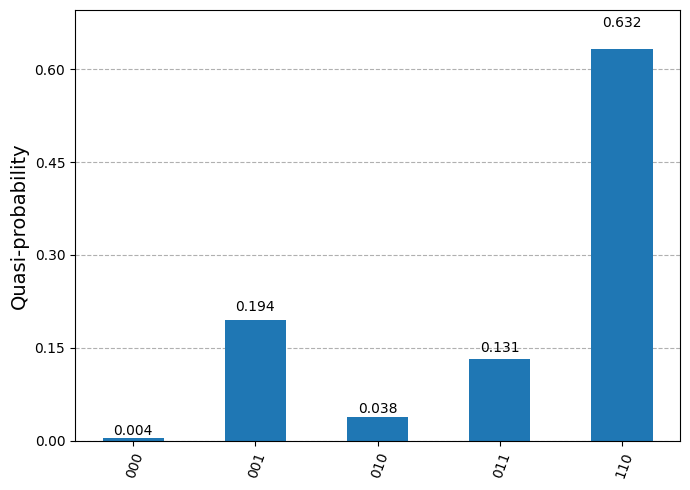

In [7]:
qc, scale_factor = qsvt.solve_linear_system_real(A, phi_qsp, s, b)

######################################################################################################################################################


qc.measure_all()
print(qc)
sim = AerSimulator()
res = sim.run(transpile(qc, sim), shots = 100000).result()
print('true sol: ', np.linalg.solve(A, b))
print(scale_factor)
plot_distribution(res.get_counts())

## 8. Post-Processing the Real QSVT Solution and Sherman–Morrison Normalization Template

This cell performs two main tasks:

1. It post-processes the measurement distribution returned by the real-valued QSVT solver in order to reconstruct the (unnormalized) real solution vector $z$.
2. It provides a reusable template for applying Sherman–Morrison normalization and Chebyshev reconstruction in problems of the form
$$
u'(x) = \alpha\,u(x).
$$



### 8.1 Filtering the Correct Subspace and Reconstructing $z$

The lines

```python
filtered = {k: v for k, v in res.get_counts().items() if k[0] == '0' and k[-1] == '0'}
arr = [filtered[k] for k in sorted(filtered)]
p = np.array(arr) / 100000
z = scale_factor * np.sqrt(p)
print('z: ', z)
```

implement the following:

- We extract only those computational-basis measurement outcomes whose **first** and **last** bits are `0`.
  - The **first bit** is the Hadamard-test ancilla.  
    A `0` here selects the branch containing the **real part** of the QSVT output.
  - The **last bit** is the block-encoding ancilla.  
    A `0` here projects onto the **top-left block** of the block-encoding, which contains the correct matrix action.

Thus the physically meaningful subspace is:
$$
\{\,k \; : \; k_0 = 0,\; k_{-1} = 0\,\}.
$$

- From these outcomes we compute probabilities
$$
p_i = \frac{\text{counts}_i}{\text{shots}},
$$
and the real amplitudes of the solution are obtained as:
$$
z_i \;=\; \text{scale\_factor}\,\sqrt{p_i}.
$$

The square root appears because measurement probabilities are squared amplitudes, and `scale_factor` accounts for:
- normalization of the input vector,
- QSVT polynomial scaling,
- block-encoding normalization,
- Hadamard-test normalization.

The vector $z$ is therefore the **real solution** of the linear system (up to normalization already absorbed into `scale_factor`).


### 8.2 Chebyshev Nodes and the DCT-I Matrix $P$

The routines

```python
def cheby_nodes(N):
    ...
def create_P(N, nodes):
    ...
```

construct:

1. Chebyshev–Gauss–Lobatto nodes
$$
x_l = \cos\!\left(\frac{l\pi}{N}\right), \qquad l = 0,\dots,N,
$$

2. The Chebyshev transform (DCT-I) matrix
$$
P_{l,k} = T_k(x_l) = \cos(k\arccos x_l).
$$

Applying the transform recovers nodal values from coefficients:
$$
x = P\,a.
$$

Although this cell constructs $P$ explicitly in $O(N^2)$ time,  
in practice one would use FFT-based DCT-I routines that run in:
$$
O(N \log N).
$$



### 8.3 Chebyshev Evaluation and Derivative

The functions

```python
cheb_eval
cheb_eval_derivative_fast
```

implement:

- Clenshaw evaluation of the Chebyshev series
$$
f(t) = \sum_{k=0}^N a_k T_k(t),
$$
in time $O(N)$.

- Fast derivative evaluation using
$$
\frac{\mathrm{d}}{\mathrm{d}t} T_k(t) = k\,U_{k-1}(t),
$$
also in $O(N)$ time, where $U_{k}$ are Chebyshev polynomials of the second kind.

These routines allow computation of both $ f(t) $ and $ f'(t) $ at any point $t$.



### 8.4 Sherman–Morrison Template for $u'(x)=\alpha u(x)$

The function

```python
def vdotz_from_point_alpha(z, t_ic, alpha):
    ...
```

computes
$$
v^\top z = (1+\alpha)\, x_z(t_{\mathrm{ic}}) - x_z'(t_{\mathrm{ic}}),
$$
where:
- $x_z(t)$ is the Chebyshev expansion with coefficients $z$,
- $x_z'(t)$ is its derivative,
- $t_{\mathrm{ic}}$ is the boundary condition location.

This provides the Sherman–Morrison normalization factor:
$$
\gamma = 1 + v^\top z.
$$

Once $\gamma$ is known, the final Chebyshev coefficient vector is:
$$
a = \frac{s}{\gamma}\,z,
$$
where $s$ is the QSVT polynomial scaling factor (if used in your convention).

Finally, nodal values follow from:
$$
x = P\,a.
$$



### 8.5 Complexity Notes

- **Filtering measurements:** proportional to number of observed outcomes (≤ number of shots).
- **Computing $z$:** $O(N)$ operations (square roots + scaling).
- **Evaluating $v^\top z$:**  
  Requires one Chebyshev evaluation and one derivative evaluation → both $O(N)$.
- **Applying DCT-I:**  
  Naively $O(N^2)$, but FFT-based implementations give $O(N\log N)$.

Thus, the Sherman–Morrison normalization adds only **linear-time classical overhead**, making it efficient for integration into QSVT-based spectral solvers.


In [8]:
filtered = {k: v for k, v in res.get_counts().items() if k[0] == '0' and k[-1] == '0'}
arr = [filtered[k] for k in sorted(filtered)]
p = np.array(arr) / 100000 # probability
z = scale_factor * np.sqrt(p)
print('z: ', z)

def cheby_nodes(N: int): # Status: OK
    nodes = np.zeros((N + 1))
    for l in range(N + 1):
        nodes[l] = np.cos(l * np.pi / N)
    return nodes
def create_P(N: int, nodes: list): # Status: OK
    P = np.zeros((N + 1, N + 1))
    for l in range(N + 1):
        for k in range(N + 1):
            P[l][k] = np.cos(k * np.arccos(nodes[l]))
    return P
def cheb_U_values(M: int, t: float):
    U = np.zeros(M+1, dtype=float)
    U[0] = 1.0
    if M >= 1:
        U[1] = 2.0 * t
        for k in range(1, M):
            U[k+1] = 2.0 * t * U[k] - U[k-1]
    return U
def cheb_eval(a: np.ndarray, t: float) -> float:
    a = np.asarray(a, dtype=float)
    N = a.size - 1
    b_kp1 = 0.0  # b_{k+1}
    b_kp2 = 0.0  # b_{k+2}
    two_t = 2.0 * t
    # k = N .. 1
    for k in range(N, 0, -1):
        b_k = a[k] + two_t * b_kp1 - b_kp2
        b_kp2, b_kp1 = b_kp1, b_k
    # f(t) = a0 + t*b1 - b2
    return float(a[0] + t * b_kp1 - b_kp2)
def cheb_eval_derivative_fast(a: np.ndarray, t: float) -> float:
    a = np.asarray(a, dtype=float)
    N = a.size - 1
    if N == 0:
        return 0.0
    U = cheb_U_values(N-1, t)  # U_0..U_{N-1}
    k = np.arange(1, N+1, dtype=float)
    return float((a[1:] * k * U).sum())
def vdotz_from_point_alpha(z: np.ndarray, t_ic: float, alpha: float) -> float:
    # x_z(t_ic) and x'_z(t_ic) as you already compute:
    x_val = cheb_eval(z, t_ic)
    x_der = cheb_eval_derivative_fast(z, t_ic)
    return (1.0 + alpha) * x_val - x_der


## These lines of codes can be used to solve the differential equation after obtaining z from QSVT

# q = 2
# N = 2**q - 1
# alpha = 5
# nodes = cheby_nodes(N)
# P = create_P(N, nodes)
# P_inv = np.linalg.inv(P)
# t_ic = -1
# gamma = 1 + vdotz_from_point_alpha(z, t_ic, alpha)
# a = (s/gamma) * (z) 
# x = P @ a
# print('x: ', x)

z:  [0.3261283  1.01746454]


## 9. Numerical Behavior and Robustness

Across a range of experiments with different:

- Matrix sizes and structures (diagonal, dense Hermitian, general non-Hermitian via Hermitian dilation),
- Condition numbers specified via the `condition_number` parameter and auxiliary generators,

we observe that:

- On a **noiseless `AerSimulator`**, the QSVT-based solutions match the classical reference solutions (computed via `np.linalg.solve`) to high precision, limited primarily by:
  - The polynomial approximation error in the QSVT synthesis (controlled by $\kappa$ and PyQSP’s tolerance).
  - The numerical conditioning of the matrix.
- When the **actual condition number** of the matrix is up to about **twice the target $\kappa$** used to generate the phases, the solver remains **numerically stable** and still produces accurate solutions.
  - This indicates a degree of robustness beyond the strict design guarantees.
- The **scalar QSVT implementation** (`qsvt_scalar`) is especially useful for:
  - Debugging the phase synthesis.
  - Understanding how the polynomial approximation behaves on individual eigenvalues or singular values.

These observations support the use of QSVT as a **Chebyshev-based differential equation solver**, where the system matrices often have structured spectra and large but manageable condition numbers.


## 10. Future Work and Extensions

This notebook demonstrates a **hybrid classical–quantum** pipeline where:

- The **Chebyshev transform** between physical space and Chebyshev coefficient space is currently implemented **classically** (e.g., via FFT-based routines).
- The **QSVT core** acts as a **quantum linear system solver** on the discretized operator.

Several key extensions are planned:

1. **Quantum Chebyshev Transform Circuit**

   - Replace the classical Chebyshev transform with a fully **quantum Chebyshev transform** implemented as a circuit.
   - This would allow:
     - Direct preparation of Chebyshev coefficient states from physical-space boundary/initial data.
     - In-place transformation back to physical space after applying QSVT.
   - Potential approaches include:
     - Quantum implementations of discrete cosine transforms (DCT) tailored to Chebyshev polynomials.
     - Encoding boundary conditions directly in the transform structure.

2. **Multi-Ancilla Block Encoding**

   - The current implementation uses a **single-ancilla block encoding** via `qml.BlockEncode`, which is qubit-efficient but can have large depth.
   - Next steps include:
     - Designing **multi-ancilla block encodings** (e.g., via FABLE) that trade extra ancilla qubits for reduced depth.
     - Comparing different block-encoding constructions in terms of:
       - Gate count,
       - Robustness to noise,
       - Overall runtime in a Chebyshev-based PDE solver.

3. **Noisy Simulators and Hardware Tests**

   - Run the same circuits on:
     - **Noisy simulators** (e.g., with realistic noise models for superconducting qubits or trapped ions).
     - Real **quantum hardware backends** where available.
   - Quantify:
     - Degradation in solution quality as a function of depth, condition number, and noise strength.
     - The effectiveness of error mitigation techniques (e.g., zero-noise extrapolation, measurement error mitigation).

4. **Larger Chebyshev Systems and PDE Benchmarks**

   - Scale up to matrices $A$ that come explicitly from:
     - High-order Chebyshev spectral discretizations of ODEs and PDEs.
     - Systems with non-trivial boundary conditions and non-Hermitian structure (e.g., advection-dominated problems).
   - Build **benchmark suites** that compare:
     - Classical spectral solvers,
     - QSVT-based solvers with classical Chebyshev transforms,
     - Fully quantum Chebyshev-QSVT pipelines.

5. **Refined Phase Synthesis and Polynomial Design**

   - Experiment with:
     - Different polynomial approximations for $\frac{1}{x}$, including tailored bands for particular spectral distributions.
     - Alternative phase-synthesis tools (e.g., QSPPACK) for optimizing depth, robustness, or error profiles.
   - Study how these choices impact the **stability and accuracy** of the Chebyshev-based QSVT solver for realistic differential equation problems.


## Acknowledgements

I gratefully acknowledge the foundational tools and open-source frameworks that made this work possible, including:  
**Qiskit** for quantum circuit synthesis and simulation, **Pennylane** for block-encoding support, and **PYQSP** for phase-sequence generation in Quantum Singular Value Transformation (QSVT).

This work also benefited from discussions with my supervisor **Prof. Anil Shaji** (Professor at School of Physics, IISER TVM) and community resources in quantum algorithms, spectral methods, and block-encoding techniques.  
The implementation and tutorial presented here were developed independently by **Sharon Xalxo** (2025) as part of ongoing research into quantum algorithms for differential equations, Chebyshev spectral discretizations, 
and QSVT-based linear system solvers.

Users of this repository or associated implementations are kindly asked to cite this work using the recommended citation or Bib\TeX{} entry provided in the documentation.
